# Ground Navigation for Aerial Vehicles

With a satellite reference image, we intend to utilize a SfM solution to match ground segments of images to the reference map.
- Inputs: Reference image (satellite), SfM solution (images, points, cameras), selected images (SINGLE)
- Output: Correction solutions for translation, rotation, scaling

### Single image as opposed to multi-image submap

In [1]:
import numpy as np
import cv2
import open3d as o3d
import plotly.graph_objects as go
import plotly.io as pio
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree
import imageio
# %matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.path import Path

from groundNAV_agent import *
from colmapParsingUtils import *
import pycolmap

# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# CLOSER IMAGES 
# Load in necessary parameters for gNAV agent 
# Define Class Parameters 

images_colm  = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/images.txt"
cameras_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/cameras.txt"
pts3d_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/points3D_f.txt"

# Images selected for local corrections
image_1 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG"
image_2 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG"
image_3 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG"
image_4 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG"
image_5 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG"
image_6 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG"
# Load in satellite reference image
sat_ref = "TTurf/TurfSat.jpg"

# Organize for agent params
images = [image_1, image_2, image_3, image_4, image_5, image_6]

In [3]:
# Create class
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, images, sat_ref)

# Grab raw points and RGB data for scene and reference cloud
scene_pts, rgb_data = gnav.grab_pts(gnav.pts3d_c)
ref_pts, ref_rgb = gnav.ref_pts, gnav.ref_rgb

In [4]:
# Use ground plane pts to set reference frame 
# Need gravity and height
pts_gnd_idx = np.array([25440, 25450, 25441, 25449, 25442, 25445, 103922, 103921, 103919, 103920])
# tform_ref_frame = gnav.set_ref_frame(pts_gnd_idx) # THIS IS WHAT I AM CHANGING 
tform_ref_frame = gnav.set_ref_frame_mid(pts_gnd_idx) # NEW VERSION
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
# Transform all points to the new coordinate system 
# Not necessary since we aren't using the cloud, but a good visual check for coord frame
tform_ref_frame_inv = gnav.inv_homog_transform(tform_ref_frame)
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(scene_pts, gnav.origin_w, tform_ref_frame_inv)
# print(origin_ref)
# Transform scene cloud to 2D (also as a visual check)
# Note: 2d projection will look off with z=-1; see TTurf_v2 for cropping method
scene_ref_2d = gnav.proj_2d_scene(scene_pts_ref)
# print(scene_ref_2d)

### 4 Sections of same image 

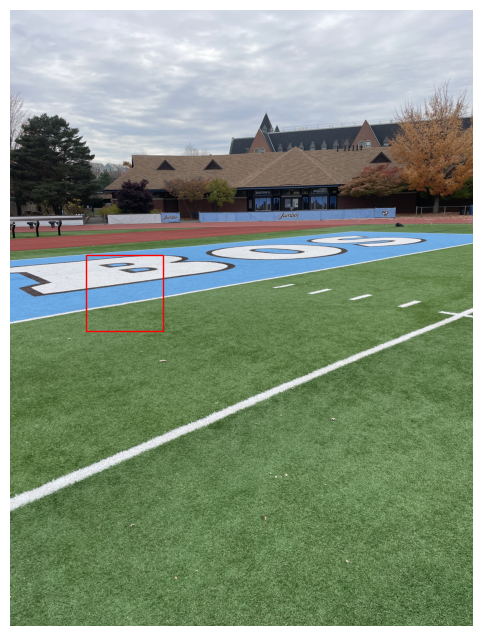

In [6]:
# Section 0 -B bottom portion 
imnum = 0
x,y = 500,1600
side_x = 500 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)

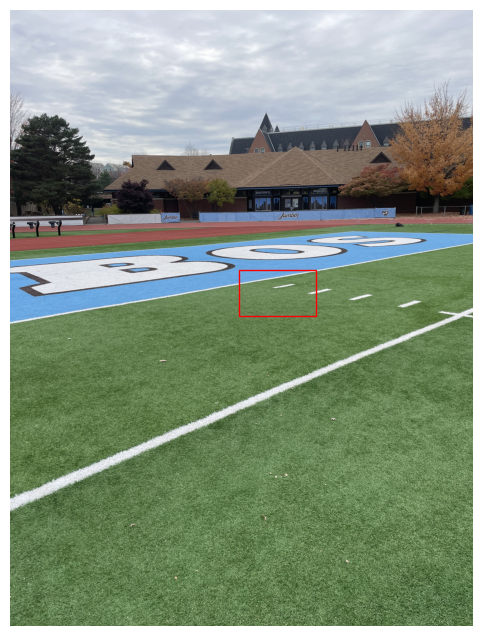

In [7]:
# Section 1 - hash and endzone section
imnum = 1
x,y = 1500,1700
side_x = 500 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)

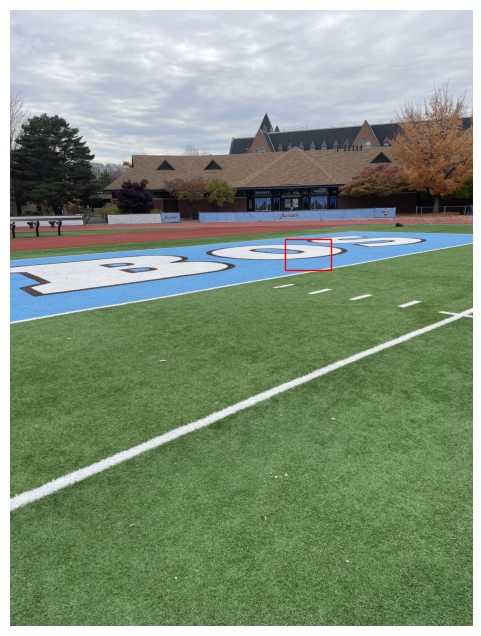

In [8]:
# Section 2 - O in jumbos
imnum = 2
x,y = 1800,1500
side_x = 300 # WIDTH
side_y = 200 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)

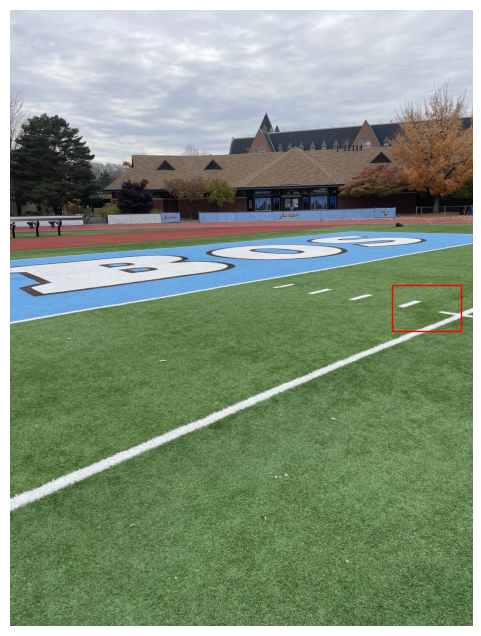

In [9]:
# Section 3 - 5yd hash
imnum = 3
x,y = 2500,1800
side_x = 450 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)

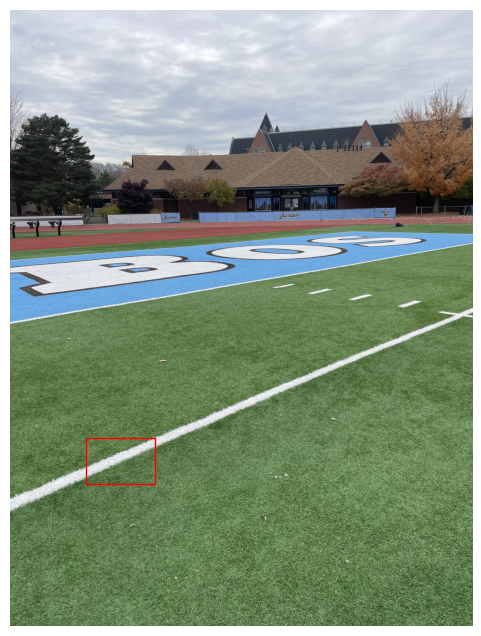

In [10]:
# Section 4 - 5yd line
imnum = 4
x,y = 500,2800
side_x = 450 # WIDTH
side_y = 300 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)

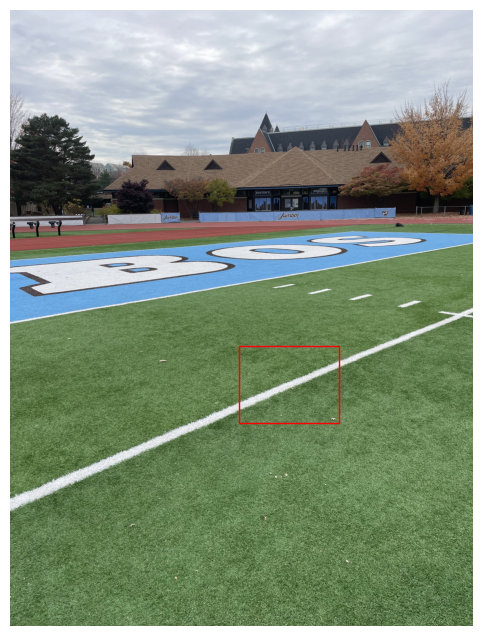

In [11]:
# Section 5 - 5yd hash
imnum = 5
x,y = 1500,2200
side_x = 650 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)

In [12]:
## Generate projection of image sections 
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    # Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # Get transformation matrix that move from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5


In [13]:
# PLOT representative figure

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene projection - COLMAP coords")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)


# POINT CLOUDS 
for i in range(len(images)):
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['pts'])
    cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
    vis.add_geometry(cloud)


vis.add_geometry(axis_origin)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2


# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


## Implement Guess and Plot

In [14]:
# Implementing an initial guess for the local image 

# SCALE for initial guess 
# scale = gnav.focal/39
scale = 80


# BEST after CONVERGENCE
scale = 80.14819958
yaw = 2.44777939
x = -55.46495001
y = 21.62910054

# NEW solution for single image
scale = 65
yaw = np.deg2rad(134)
x = -46
y = 13


tform_guess = gnav.tform_create(x,y,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale
# print(tform_guess)


# NEW IMPLEMENTATION STRATEGY
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    loc_im_pts = gnav.im_mosaic[i]['pts'].copy()
    # print(loc_im_pts)

    loc_im_pts[:, :2] *= scale # For SINGLE scale factor
    # Get new points 
    __, loc_im_pts_guess, loc_im_vec_guess = gnav.unit_vec_tform(loc_im_pts, gnav.origin_w, tform_guess)
    gnav.im_pts_best_guess[i] = {'pts': loc_im_pts_guess}
    # gnav.im_pts_best_guess[i]['tree'] = cKDTree(loc_im_pts_guess) # UNECESSARY 

    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5


In [15]:
# PLOT representative figure

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene projection - COLMAP coords")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=40)


# POINT CLOUDS 
for i in range(len(images)):
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
    cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
    vis.add_geometry(cloud)

# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

vis.add_geometry(ref_cloud)
vis.add_geometry(axis_origin)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2


# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [16]:
n = 10
for imnum in range(len(images)):
# Just for the first image for now 
# for imnum in range(1):
# for imnum in range(5, 6, 1):
    print(imnum)
    ssds = gnav.ssd_nxn(n, imnum)
    gnav.ssds_curr[imnum] = ssds
print("Done, most recent SSDs are\n", ssds)

0
Number of points used for image 0:  (4037,)
1
Number of points used for image 1:  (1508,)
2
Number of points used for image 2:  (3428,)
3
Number of points used for image 3:  (708,)
4
Number of points used for image 4:  (48,)
5
Number of points used for image 5:  (353,)
Done, most recent SSDs are
 [[18.92549709 18.80487033 18.78432976 18.61190973 18.57289962 18.5442384
  18.43629257 18.42043873 18.20150115 18.00001385 18.01498803 17.81601988
  17.72136769 17.52650567 17.35738537 17.33312451 17.31366171 17.21567746
  17.08501332 17.00561463 17.01340992]
 [20.51320899 20.51196969 20.47826819 20.37283657 20.13378622 20.04627312
  20.04999864 19.83605723 19.5372474  19.39064124 19.35318243 19.27053727
  19.13172875 18.87203682 18.54668187 18.50518997 18.50234129 18.50579892
  18.3215973  18.16343508 18.41840887]
 [22.21415588 22.2165322  21.98884259 21.92689986 21.74338113 21.63523489
  21.60378515 21.35661499 21.23523491 21.05778109 21.02793219 20.99173599
  20.73455492 20.37581529 20.32

In [17]:
# Create a vector from the original position to the minimum SSD location 
cor_vecs = np.zeros((len(images), 2))
base_vec = np.zeros((len(images), 2))
for im_cv in range(len(images)):
# for imnum in range(1):
    # Grab SSDs - get id of minimum
    ssds = gnav.ssds_curr[im_cv]
    # print(f"\nSSDS for image {i}\n", ssds)
    idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
    # print("\nidrow, idcol\n", idrow, idcol)
    # Define best shift vector 
    shiftx_min = idrow-n
    shifty_min = idcol-n
    # CHECK IF MIN SSD IS ON EDGE
    # if shiftx_min == n or shifty_min == n:
    #     print(f"\n Need to extend search of image {im_cv}\n")
    #     print(f"\n Current shift vector = {shiftx_min, shifty_min}\n")
    #     ssds = gnav.ssd_nxn(n+extend, im_cv)
    #     gnav.ssds_curr[im_cv] = ssds
    #     idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
    #     shiftx_min = idrow-(n+extend)
    #     shifty_min = idcol-(n+extend)
    #     print(f"\n New shift vector = {shiftx_min, shifty_min}\n")
        
    
    # print("\nBEST SHIFT VECTOR = ", shiftx_min, shifty_min)
    # print(f"\nBEST SSD for image {im_cv} = ", ssds[idrow, idcol])
    cor_vecs[im_cv] = shiftx_min, shifty_min
    # Get mean of satellite points for base of x and y
    sat_pts, __ = gnav.get_inside_sat_pts(im_cv, 0,0)#shiftx_min, shifty_min)
    # print("\nInside satellite points\n", sat_pts)
    basex, basey = np.mean(sat_pts[:,0]), np.mean(sat_pts[:,1])
    # print("\nBase of x and y = ", basex, basey)
    base_vec[im_cv] = basex, basey

In [18]:
print(cor_vecs)
yi = cor_vecs.reshape(-1,1)
print("\nYi\n", yi)
gnav.ssds_fin = yi
gnav.ssds_fin[10] = 0
gnav.ssds_fin[11] = -4
print(gnav.ssds_fin[10])

[[-5. -1.]
 [-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 0. -5.]
 [ 0. -4.]]

Yi
 [[-5.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 0.]
 [-5.]
 [ 0.]
 [-4.]]
[0.]


In [19]:
# Create matrix to match patches
# First, using magnitude of location and residual 

# Empty matrix for patch residuals 
res_pat = np.zeros((len(images), len(images), 2))
res_pat_X = np.zeros((len(images), len(images), 2))
res_pat_Y = np.zeros((len(images), len(images), 2))
print(res_pat)

for i in range(len(images)):
    for j in range(len(images)):
        p1 = i
        p2 = j
        # Mean location difference of each patch 
        p1x = np.mean(gnav.im_pts_best_guess[p1]['pts'][:,0])
        p1y = np.mean(gnav.im_pts_best_guess[p1]['pts'][:,1])
        p2x = np.mean(gnav.im_pts_best_guess[p2]['pts'][:,0])
        p2y = np.mean(gnav.im_pts_best_guess[p2]['pts'][:,1])
        pdx = p1x-p2x
        pdy = p1y-p2y
        # Magnitude of difference 
        magdif = np.sqrt(pdx**2 + pdy**2)
        print(f"\ni = {i}, j = {j}, diff in x and y = {pdx,pdy}\n")
        print(f"\nDifference location magnitude = {magdif}")
        
        # SSDs for patches
        ssd1x = gnav.ssds_fin[2*i,0]
        ssd1y = gnav.ssds_fin[2*i+1,0]
        ssd2x = gnav.ssds_fin[2*j,0]
        ssd2y = gnav.ssds_fin[2*j+1,0]
        ssdx = ssd1x - ssd2x
        ssdy = ssd1y - ssd2y
        # Magnitude of SSD difference 
        ssdmag = np.sqrt(ssdx**2 + ssdy**2)
        print("\nSSD in x, y, patch 1, 2: ", ssd1x, ssd1y, ssd2x, ssd2y)
        print("\nSSD difference in x, y: ", ssdx, ssdy)
        res_pat[i][j] = ssdmag, magdif
        res_pat_X[i][j] = ssdx, pdx
        res_pat_Y[i][j] = ssdy, pdy



[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]

i = 0, j = 0, diff in x and y = (0.0, 0.0)


Difference location magnitude = 0.0

SSD in x, y, patch 1, 2:  -5.0 -1.0 -5.0 -1.0

SSD difference in x, y:  0.0 0.0

i = 0, j = 1, diff in x and y = (38.84429972092393, -25.520600669732545)


Difference location magnitude = 46.477743914188906

SSD in x, y, patch 1, 2:  -5.0 -1.0 -1.0 -1.0

SSD difference in x, y:  -4.0 0.0

i = 0, j = 2, diff in x and y = (-21.856872104197755, -105.39301657555208)


Difference location magnitude = 107.63554617817412

SSD in x, y, patch 1, 2:  -5.0 -1.0 -1.0 1.0

SSD difference in x, y:  -4.0 -2.0

i = 0, j = 3, diff in x and y = (76.66479936

Text(0.5, 1.0, 'Location diff vs. Residual diff between different patches')

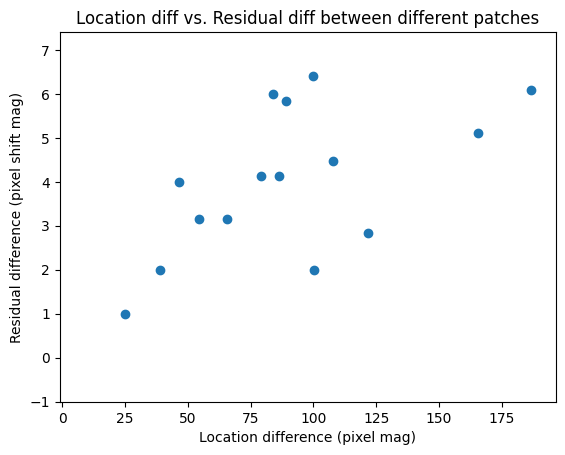

In [20]:
# Plot and visualize residuals

# PLOTTING A SINGLE VECTOR FIELD FOR SSD
# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111)

# Get the upper triangle indices (excluding diagonal)
i_indices, j_indices = np.triu_indices(6, k=1)

# Extract vectors from res_pat[i, j]
a = res_pat[i_indices, j_indices, 0]  # Residual differences
b = res_pat[i_indices, j_indices, 1]  # Location differences

# a = res_pat[:][:][:,0]
# b = res_pat[:,1]

# Plot the points
ax.plot(b, a, 'o')

# Set axis limits
ax.set_xlim([-1, np.max(b) + 10])
ax.set_ylim([-1, np.max(a) + 1])

# Labels and title
ax.set_xlabel('Location difference (pixel mag)')
ax.set_ylabel('Residual difference (pixel shift mag)')
ax.set_title('Location diff vs. Residual diff between different patches')

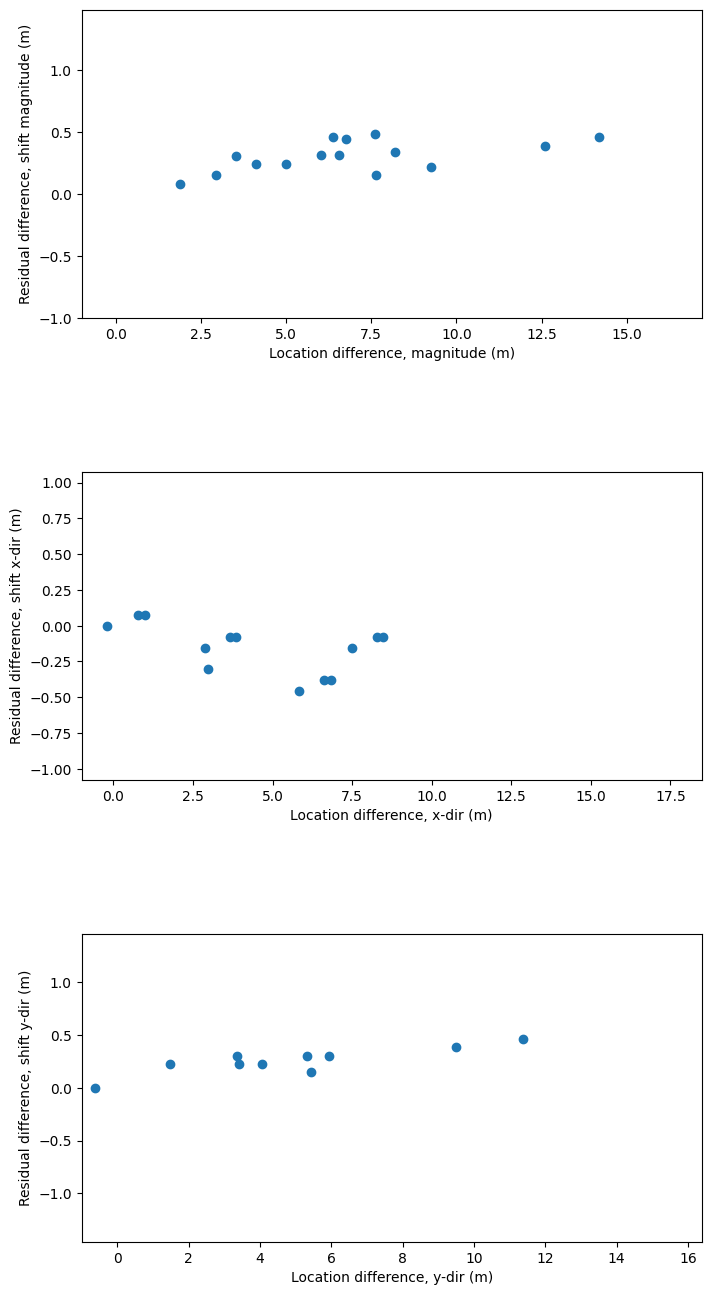

In [23]:
# CONVERSION TO FEET 
ppf = 4.004996878900157 # Pixels per foot
fpp = 1/ppf # Feet per pixel 
ppm = 13.139713910202001 # Pixels per meter
mpp = 1/ppm # Meters per pixel

# Plot and visualize residuals
# Create the figure and 3D axis
# fig = plt.figure()
fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)



# MAGNITUDE*************
# Extract vectors from res_pat[i, j]
a = res_pat[i_indices, j_indices, 0]  # Residual differences
a *= mpp # Residual differences (meters mag)
b = res_pat[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax1.plot(b, a, 'o')

# Set axis limits
ax1.set_xlim([-1, np.max(b) + 3])
ax1.set_ylim([-1, np.max(a) + 1])

# Labels and title
ax1.set_xlabel('Location difference, magnitude (m)')
ax1.set_ylabel('Residual difference, shift magnitude (m)')
# ax1.set_title('Residuals diff between patches (meters, MAGNITUDE)')



# JUST THE X ***********
# Extract vectors from res_pat[i, j]
a = res_pat_X[i_indices, j_indices, 0]  # Residual differences (SSD)
a *= mpp # Residual differences (meters mag)
b = res_pat_X[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax2.plot(b, a, 'o')

# Set axis limits
ax2.set_xlim([-1, np.max(b) + 10])
ax2.set_ylim([-np.max(a)-1, np.max(a) + 1])

# Labels and title
ax2.set_xlabel('Location difference, x-dir (m)')
ax2.set_ylabel('Residual difference, shift x-dir (m)')
# ax2.set_title('Residuals diff between patches (meters, X-DIR)')




# JUST THE Y ********************
# Extract vectors from res_pat[i, j]
a = res_pat_Y[i_indices, j_indices, 0]  # Residual differences
a *= mpp # Residual differences (meters mag)
b = res_pat_Y[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax3.plot(b, a, 'o')




# Set axis limits
ax3.set_xlim([-1, np.max(b) + 5])
ax3.set_ylim([-np.max(a)-1, np.max(a) + 1])

# Labels and title
ax3.set_xlabel('Location difference, y-dir (m)')
ax3.set_ylabel('Residual difference, shift y-dir (m)')
# ax3.set_title('Residuals diff between patches (meters, Y-DIR)')



fig.subplots_adjust(hspace=0.5)
plt.show()

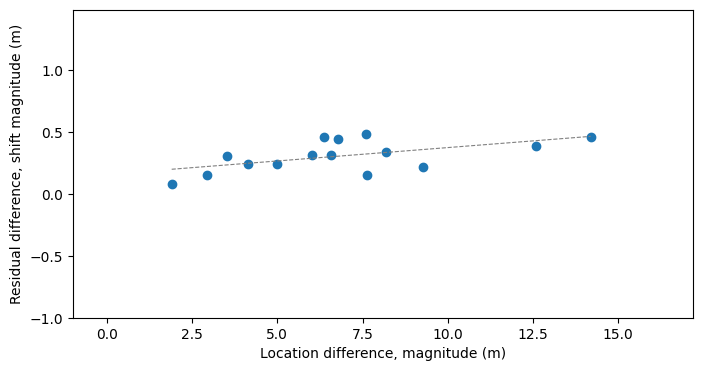

In [25]:
# CONVERSION TO FEET 
ppf = 4.004996878900157 # Pixels per foot
fpp = 1/ppf # Feet per pixel 
ppm = 13.139713910202001 # Pixels per meter
mpp = 1/ppm # Meters per pixel

# Plot and visualize residuals
# Create the figure and 3D axis
# fig = plt.figure()
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)



# MAGNITUDE*************
# Extract vectors from res_pat[i, j]
a = res_pat[i_indices, j_indices, 0]  # Residual differences
a *= mpp # Residual differences (meters mag)
b = res_pat[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax1.plot(b, a, 'o')

# ----- Trendline -----
coeffs = np.polyfit(b, a, deg=1)  # Fit a line: y = mx + c
trendline = np.poly1d(coeffs)
x_vals = np.linspace(np.min(b), np.max(b), 100)
# ax1.plot(x_vals, trendline(x_vals), '--',color='black', label=f"Trendline: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}")
ax1.plot(
    x_vals,
    trendline(x_vals),
    color='gray',
    linewidth=0.8,
    linestyle='--',
    label=f"Trendline: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}"
)


# Set axis limits
ax1.set_xlim([-1, np.max(b) + 3])
ax1.set_ylim([-1, np.max(a) + 1])

# Labels and title
ax1.set_xlabel('Location difference, magnitude (m)')
ax1.set_ylabel('Residual difference, shift magnitude (m)')
# ax1.set_title('Residuals diff between patches (meters, MAGNITUDE)')

plt.show()